# <center> <font color="#8333ff"> Projet8 : Déployez un modèle dans le cloud </font></center>

## Problématique : 

Vous êtes Data Scientist dans une très jeune start-up de l'AgriTech, nommée  **"Fruits!"**, qui cherche à proposer des 
solutions innovantes pour la récolte des fruits.
Cette entreprise souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application
mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.
Le développement de l’application mobile permettra de construire **une première version de l'architecture Big Data 
nécessaire.**

## Mission :
Vous êtes donc chargé de développer dans un environnement Big Data une première chaîne de traitement des données qui 
comprendra le preprocessing et une étape de réduction de dimension.

## <font color="blue">Sommaire</font>

1. [Point de départ : la session Spark](#section_1)   
2. [Chargement et Lecture des données](#section_2)              
3. [Utilisation d'un modèle pré-entrainé ResNet50 ](#section_3) </br>
4. [Préprocessing et création des features](#section_4) </br>
5. [Réduction de dimension](#section_5) </br>
6. [Sauvegarde des données au format paquet ](#section_6) </br>


Dans ce notebook, nous allons manipuler un faible jeu de données, de 10 images seulement, et travailler en local.

Cela va nous permettre de préparer notre notebook sur un petit jeu de données donc, cela sera plus rapide, mais aussi
d'éviter d'utiliser des heures gratuits d'aws pour la préparation de notre notebook, que nous préférons garder pour la 
partie où l'on transfère notre notebook sur l'EC2 AWS.

Tout d'abord commençons par installer la libraire nécessaire pour utiliser pyspark.

pip install findspark

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark'

On importe aussi la librairie nécessaire pour notre projet.

In [2]:
from pyspark.sql.functions import *

In [3]:
#Pyspark
from pyspark import SparkContext, SparkConf

from pyspark.ml.feature import StandardScaler, StringIndexer

from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, IntegerType, FloatType, StringType
from pyspark.sql.functions import split, col, udf
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import element_at
from pyspark.sql.functions import monotonically_increasing_id, row_number

from pyspark.ml.linalg import Vectors, VectorUDT

## <font color="red" id="section_1">1.  Point de départ : la session Spark </font>

Mettons d'abord en place les chemins d'accès servant à récupérer nos images.

In [4]:
import os

#Les données se trouvent dans le même dossier que notre outil python
Chemin = os.getcwd()
#Lien des 10 images
Chemin_Image = Chemin+'/test'
#Lien du résultat final
Chemin_Res = Chemin+'/resultat'
#On vérifie les liens
print('Chemin:        '+\
      Chemin+'\nChemin_Image:   '+\
      Chemin_Image+'\nChemin_Res: '+Chemin_Res)

Chemin:        C:\Users\laila
Chemin_Image:   C:\Users\laila/test
Chemin_Res: C:\Users\laila/resultat


Le point d'entrée de toutes les fonctionnalités de Spark est la création d'une session Spark, à l'aide de 
"SparkSession.builder".

In [5]:
from pyspark.sql import SparkSession

#Création d'une session Spark
spark = (SparkSession
             .builder
             .appName("Fruits")
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

La première chose à faire lorsque l'on veut utiliser Spark est de créer un objet SparkContext, 
généralement assigné à une variable nommée sc dans le code. Cet objet indique à Spark comment accéder 
au cluster de serveurs que vous souhaitez utiliser.
Spark est un framework de calcul distribué (ce n'est pas un langage de programmation).
Le calcul distribué consiste en la réalisation d’opérations sur des données qui ne sont pas stockées en un seul endroit,
mais éparpillées au sein d’un réseau de différentes machines (un « cluster »).

Ici, notre cluster est local (pour faire des tests en simulant plusieurs processus parallèles comme s’il s’agissait de serveurs différents). 

In [6]:
from pyspark import SparkContext

sc = spark.sparkContext

In [7]:
spark

## <font color="red" id="section_2">2. Chargement et Lecture des données </font>

Nous allons stocker les images, que nous avions placé dans un dossier "test", dans le dataset nommé "images".

In [8]:
#Lecture des données images 
data_img = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(Chemin_Image)

Nous allons maintenant construire un tableau contenant les liens des images ('path') dans une colonne et les libellés du 
fruit concerné dans l'autre colonne ('label').

In [9]:
#On ajoute une nouvelle colonne 'fruit' à l'aide du nom du fruit présent dans 'path'
data_img = data_img.withColumn('fruit', element_at(split(data_img['path'], '/'),-2))

#On affiche le schema de nos manipulations
print(data_img.printSchema())
#On affiche le chemin et nom des fruits
print(data_img.select('path','fruit').show(10,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- fruit: string (nullable = true)

None
+---------------------------------------------------+--------------+
|path                                               |fruit         |
+---------------------------------------------------+--------------+
|file:/C:/Users/laila/test/Apple Braeburn/3_100.jpg |Apple Braeburn|
|file:/C:/Users/laila/test/Apple Braeburn/4_100.jpg |Apple Braeburn|
|file:/C:/Users/laila/test/Apple Braeburn/8_100.jpg |Apple Braeburn|
|file:/C:/Users/laila/test/Apple Braeburn/7_100.jpg |Apple Braeburn|
|file:/C:/Users/laila/test/Apple Braeburn/6_100.jpg |Apple Braeburn|
|file:/C:/Users/laila/test/Apple Braeburn/5_100.jpg |Apple Braeburn|
|file:/C:/Users/laila/test/Apple Braeburn/33_100.jpg|Apple Braeburn|
|file:/C:/Users/laila/test/Apple Braeburn/9_100.jpg |Apple Braeburn|
|file:/C:/Users/laila/test/Appl

In [10]:
#On vérifie qu'il y a bien 10 images
data_img.count()

10

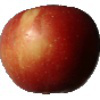

In [11]:
from PIL import Image
import io

#collect permet simplement de lancer l’évaluation effective des transformations en amont.
collect = data_img.select('content').collect()

#image située dans la première ligne, première colonne
image1 = collect[0][0]
image_1 =Image.open(io.BytesIO(image1 ))
image_1

In [12]:
#Taille de l'image 1
image_1.size

(100, 100)

## <font color="red" id="section_3"> 3. Utilisation d'un modèle pré-entrainé ResNet50 </font>

Nous allons utiliséun algotirhme de transfer learning, mais aussi modèle pré-entrainé 
sur une multitude d'images puisque nous ne devons pas, dans ce projet, entrainé un modèle.
Prenons le modèle CNN Réseau de neurones ResNet50.

ResNet-50 est un réseau neuronal convolutif de 50 couches de profondeur. 
Vous pouvez charger une version pré-entraînée du réseau formée sur plus d'un million d'images à partir 
de la base de données ImageNet [1] . Le réseau pré-entraîné peut classer les images en 1000 catégories d'objets,
telles que les fruits, le clavier, la souris, le crayon et de nombreux animaux. En conséquence, le réseau a appris des
représentations de caractéristiques riches pour une large gamme d'images. Le réseau a une taille d'entrée d'image
de 224 par 224.

In [13]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

#'imagenet' : pré-formation sur ImageNet
#pooling='avg' : la mise en commun moyenne globale sera appliquée à la sortie du dernier bloc convolutionnel,
#et donc la sortie du modèle sera un tenseur 2D.
model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
# On vérifie que la couche supérieure est supprimée
model.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [14]:
# distribution et transformation des données en leur attribuant un poids issu du modèle Resnet50
bc_model_weights = sc.broadcast(model.get_weights())

In [15]:
#Fonction qui applique le modèle resnet50 aux données
def model_fn():
    """ 
    Retourne un modèle ResNet50 sans la couche supérieure et avec diffusion des poids pré-entraînés
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

## <font color="red" id="section_4"> 4. Preprocessing et création des features </font>

Nous allons redimensionner les images en taille 224x224 car cela est nécessaire pour appliquer le modèle de transfer 
learning.

Je me suis inspirée des scripts présent dans :
    "https://docs.databricks.com/machine-learning/preprocess-data/transfer-learning-tensorflow.html"

In [16]:
from tensorflow.keras.utils import img_to_array

def preprocess(content):
    '''
    - Retourne des images prétraités pour la prédiction
    '''
    image = Image.open(io.BytesIO(content)).resize([224, 224])
    array = img_to_array(image)
    return preprocess_input(array)


In [17]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import  col, pandas_udf, PandasUDFType
from pyspark.sql.types import ArrayType, IntegerType, FloatType, StringType

def featurize_series(model, content_series):
    '''
    - Extraction des features d'un pd.Series d'images brutes à l'aide du modèle d'entrée
    - Retourne un pd.Série de features des images
    '''
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # Pour certaines couches, les entités de sortie seront des tenseurs multidimensionnels.
    # Nous aplatissons les tenseurs de caractéristiques en vecteurs pour un stockage plus facile dans Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

#On applique le modèle dans un pandas UDF
@pandas_udf('array<float>', functionType=PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    Cette méthode est une UDF Scalar Iterator pandas enveloppant la fonction d'extraction des features.
    - Prend en entrée "content_series_iter", un itérateur sur des lots de données, où chaque lot est une
      série de pandas de données d'image.
    - Retourne une colonne Spark DataFrame de type ArrayType(FloatType).
    '''
    # Avec Scalar Iterator pandas UDFs, nous pouvons charger le modèle une fois puis le réutiliser
    # pour plusieurs lots de données. Cela amortit les frais généraux liés au chargement de gros modèles.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

C:\Spark\python\pyspark\sql\pandas\functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [18]:
# Les UDF de Pandas sur de grands enregistrements (par exemple, de très grandes images) peuvent rencontrer des erreurs de type Out Of Memory (OOM).
# Si vous rencontrez de telles erreurs dans la cellule ci-dessous, essayez de réduire la taille du lot Arrow via `maxRecordsPerBatch
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [19]:
#Regardons le nombre de partitions de images
data_img.rdd.getNumPartitions()

1

In [20]:
#On garde les colonnes 'path', 'fruit','features' que l'on récupère à l'issue du préprocessing
data_features = data_img.repartition(1).select(col('path'),col('fruit'),featurize_udf("content").alias("features"))

In [21]:
#On affiche les 10 premières lignes
data_features.show(10)

+--------------------+--------------+--------------------+
|                path|         fruit|            features|
+--------------------+--------------+--------------------+
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|
+--------------------+--------------+--------------------+



## <font color="red" id="section_5">5. Reduction de dimensions </font>

## ACP

L'ACP forme un modèle pour projeter des vecteurs dans un espace dimensionnel inférieur
des k composants principaux principaux

Commençons par convertir les features en vecteurs de features.

In [22]:
from pyspark.ml.linalg import Vectors, VectorUDT

# Conversion au format vecteur dense
ud_f = udf(lambda x: Vectors.dense(x), VectorUDT())
data_vect = data_features.withColumn('features_vect', ud_f('features'))

On applique la transformation PCA pour réduire les dimensions de notre base de données.

In [23]:
from pyspark.ml.feature import StandardScaler, PCA

#On standardise les features
scaler = StandardScaler(inputCol="features_vect")
scaler.setOutputCol("features_std")
data_fit=scaler.fit(data_vect)
data_sc = data_fit.transform(data_vect)

In [24]:
data_sc.show()

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         fruit|            features|       features_vect|        features_std|
+--------------------+--------------+--------------------+--------------------+--------------------+
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.12...|[0.0,0.0,0.0,3.16...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/la...|Apple Braeburn|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0

In [25]:
# Transformation PCA sur les k premières composantes

pca = PCA(k=20,inputCol='features_std',outputCol='features_pca')

In [26]:
#On entraine et transforme les données standardisées pour obtenir les données après transformation PCA
model_pca=pca.fit(data_sc)
data_pca = model_pca.transform(data_sc)
data_pca = data_pca.filter(data_pca.features_pca.isNotNull())

In [27]:
#On affiche les 10 premières lignes de data_pca
data_pca.select(col('features'),col('features_vect'),col('features_std'),col('features_pca')).show(10)

+--------------------+--------------------+--------------------+--------------------+
|            features|       features_vect|        features_std|        features_pca|
+--------------------+--------------------+--------------------+--------------------+
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[66.0187261929501...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.12...|[0.0,0.0,0.0,3.16...|[80.2327033812707...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[54.1294498100166...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[65.6670396706145...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[64.6438638817896...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[65.5216379401284...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[-93.417004625013...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|[54.5282055315515...|
|[0.0, 0.0, 0.0, 0...|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.

## Variance expliquée

In [28]:
variance = np.round(100*model_pca.explainedVariance.toArray(),2).cumsum()
variance

array([ 31.45,  45.67,  55.84,  65.14,  73.75,  81.11,  88.23,  94.35,
       100.  , 100.  ])

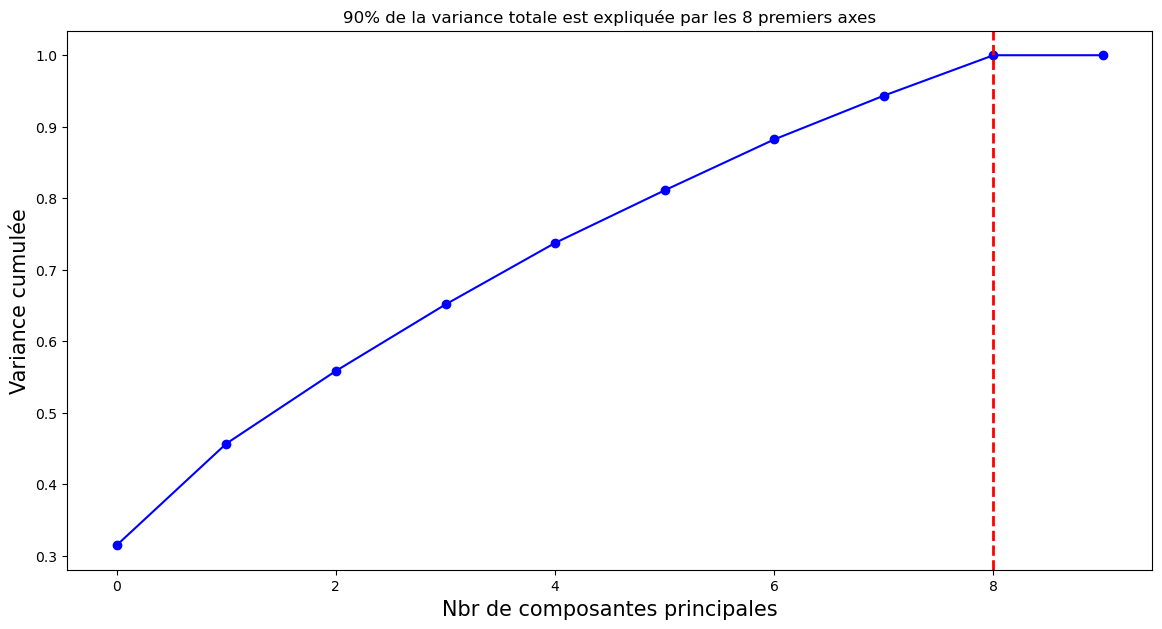

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(model_pca.explainedVariance.cumsum(), c='blue' , marker ='o')
plt.ylabel("Variance cumulée", fontsize= 15)
plt.xlabel('Nbr de composantes principales', fontsize= 15)

seuil = 90
explained_variance = model_pca.explainedVariance*100
cumsum_variance = explained_variance.cumsum()

X_idx = np.where(cumsum_variance >= seuil)[0]
nb_composante = X_idx[cumsum_variance[X_idx].argmin()]+1
plt.axvline(x=nb_composante, linestyle="--", color="red",linewidth=2)

plt.title("{}% de la variance totale est expliquée"\
            " par les {} premiers axes".format(seuil,nb_composante))

plt.show()

## <font color="red" id="section_6">6. Sauvegarde des données au format paquet </font>

In [31]:
data_final = data_pca.select(col('path'), col('fruit'), col('features_pca'))

In [32]:
data_final.show()

+--------------------+--------------+--------------------+
|                path|         fruit|        features_pca|
+--------------------+--------------+--------------------+
|file:/C:/Users/la...|Apple Braeburn|[66.0187261929501...|
|file:/C:/Users/la...|Apple Braeburn|[80.2327033812707...|
|file:/C:/Users/la...|Apple Braeburn|[54.1294498100166...|
|file:/C:/Users/la...|Apple Braeburn|[65.6670396706145...|
|file:/C:/Users/la...|Apple Braeburn|[64.6438638817896...|
|file:/C:/Users/la...|Apple Braeburn|[65.5216379401284...|
|file:/C:/Users/la...|Apple Braeburn|[-93.417004625013...|
|file:/C:/Users/la...|Apple Braeburn|[54.5282055315515...|
|file:/C:/Users/la...|Apple Braeburn|[-83.499604470547...|
|file:/C:/Users/la...|Apple Braeburn|[-96.523181661748...|
+--------------------+--------------+--------------------+



On enregistre les résultats de l'ACP (après modélisation) au format parquet.

In [33]:
data_final.write.mode("overwrite").parquet(Chemin_Res)